# Q-Networks for Hexagon Chess

## Setup

In [1]:
# Setup
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow.keras as krs
plt.style.use("tableau-colorblind10")
plt.rcParams.update({'font.size': 14})
gpus = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(gpus[0], True)
print(gpus[0])

2024-04-06 13:47:46.984219: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-06 13:47:47.902627: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-04-06 13:47:47.902734: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such fi

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-04-06 13:47:49.152252: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-06 13:47:49.218018: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-06 13:47:49.220029: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
# Hex Chess Environment & Players
from hexchess.board import HexChessBoard
from engines.environment import HexChessEnv
from engines.qnetworks import QNetworkAgent, QLearning
from hexchess.players import RandomPlayer, GreedyPlayer
from utils import plot_step_rewards, plot_episode_rewards

pygame 2.5.2 (SDL 2.28.2, Python 3.10.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
# Constants
base_path = os.path.join("assets", "qnetworks")
figs_path = os.path.join("figures", "qnetworks")

## The environment

In [5]:
# Teach Q networks to play against a random agent playing white
opponent_class = GreedyPlayer
opponent_is_white = False
apply_negative_scores = False
board_kwargs = {
    "initialize_random": True,
    "save_dir": os.path.join("states", f"{np.random.randint(1000, 10000)}".zfill(5)),
}
env = HexChessEnv(
    opponent_class, 
    opponent_is_white, 
    apply_negative_scores=apply_negative_scores, 
    board_kwargs=board_kwargs
)

In [6]:
env.render()

     B K N R P * 
    Q B * * P * * 
   N * B * P * * * 
  R * * * P * * * * 
 P P P P P * * * * * 
* * * * * * * * * * * 
 * * * * * P P P P P 
  * * * * P * * * R 
   * * * P * B * N 
    * * P * * B K 
     * P R N Q B 


## The Agent

In [7]:
# Configure agent
is_large = True
use_pretrained_weights = True
pretrained_model_path = "./assets/qnetworks/randomgreedy_pr_white_large" if use_pretrained_weights else None

In [8]:
# Construct model name
pretrained_pre_ = os.path.splitext(os.path.basename(pretrained_model_path))[0].split("_")[0] if pretrained_model_path is not None else ""
opponent_name = opponent_class.name.split(" ")[0].lower()
_reward_app = "_nr" if apply_negative_scores else "_pr"
model_color = "black" if opponent_is_white else "white"
_large_app = "_large" if is_large else ""
model_name = f"{pretrained_pre_}{opponent_name}{_reward_app}_{model_color}{_large_app}"
print(model_name)

randomgreedygreedy_pr_white_large


In [9]:
# Initialize 
agent = QNetworkAgent(
    model_path=pretrained_model_path, 
    is_large=is_large, 
    discount_factor=0.1, 
    learning_rate=1e-3
)

2024-04-06 13:48:14.531441: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-06 13:48:14.532930: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-06 13:48:14.536392: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-06 13:48:14.538933: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at 

In [10]:
agent.fix_model()
agent.model_fixed.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_skip_block_3 (Conv2D  (None, 11, 11, 6)        990       
 SkipBlock)                                                      
                                                                 
 up_sampling2d_2 (UpSampling  (None, 33, 33, 6)        0         
 2D)                                                             
                                                                 
 conv2d_skip_block_4 (Conv2D  (None, 33, 33, 6)        990       
 SkipBlock)                                                      
                                                                 
 up_sampling2d_3 (UpSampling  (None, 99, 99, 6)        0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 95, 95, 6)        

## Learn

In [11]:
# Learning configuration
n_episodes = 5000
model_fix_episodes = 10
max_episode_length = 50
batch_size = 512
memory_size = batch_size * 4

In [12]:
q_learning = QLearning(agent, env, memory_size=memory_size)

In [ ]:
episode_rewards, step_rewards = q_learning.learn(
    n_episodes=n_episodes,
    model_fix_episodes=model_fix_episodes,
    max_episode_length=max_episode_length,
    batch_size=batch_size,
)

2024-04-06 13:48:22.569403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200


Episodes 0 - 10: Mean reward 0.7
Episodes 10 - 20: Mean reward 0.5
Episodes 20 - 30: Mean reward 2.2
Episodes 30 - 40: Mean reward 2.1
Episodes 40 - 50: Mean reward 1.6
Episodes 50 - 60: Mean reward 0.7
Episodes 60 - 70: Mean reward 0.9


2024-04-06 13:48:32.228638: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fe0014f3e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-06 13:48:32.228679: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-04-06 13:48:32.556146: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Episodes 70 - 80: Mean reward 0.7
Episodes 80 - 90: Mean reward 0.6
Episodes 90 - 100: Mean reward 2.8
Episodes 100 - 110: Mean reward 0.7
Episodes 110 - 120: Mean reward 2.2
Episodes 120 - 130: Mean reward 0.5
Episodes 130 - 140: Mean reward 1.9
Episodes 140 - 150: Mean reward 0.6
Episodes 150 - 160: Mean reward 0.5
Episodes 160 - 170: Mean reward 1.5
Episodes 170 - 180: Mean reward 0.2
Episodes 180 - 190: Mean reward 0.9
Episodes 190 - 200: Mean reward 1.8
Episodes 200 - 210: Mean reward 2.8
Episodes 210 - 220: Mean reward 0.4
Episodes 220 - 230: Mean reward 0.2
Episodes 230 - 240: Mean reward 0.4
Episodes 240 - 250: Mean reward 1.6
Episodes 250 - 260: Mean reward 0.8
Episodes 260 - 270: Mean reward 1.5
Episodes 270 - 280: Mean reward 1.5
Episodes 280 - 290: Mean reward 1.5
Episodes 290 - 300: Mean reward 1.2
Episodes 300 - 310: Mean reward 1.0
Episodes 310 - 320: Mean reward 0.5
Episodes 320 - 330: Mean reward 1.3
Episodes 330 - 340: Mean reward 0.5
Episodes 340 - 350: Mean reward 1

### Save results

In [ ]:
# Save results
agent.model.save(os.path.join("assets", "qnetworks", f"{model_name}"))
np.savetxt(os.path.join(base_path, f"{model_name}_episode_rewards.csv"), episode_rewards, delimiter=",")
np.savetxt(os.path.join(base_path, f"{model_name}_step_rewards.csv"), step_rewards, delimiter=",")

INFO:tensorflow:Assets written to: assets/qnetworks/randomgreedygreedy_pr_white_large/assets


INFO:tensorflow:Assets written to: assets/qnetworks/randomgreedygreedy_pr_white_large/assets


### Load Results

In [23]:
# Model configuration
opponent_class = GreedyPlayer
opponent_is_white = False
apply_negative_scores = False
is_large = True
use_pretrained_weights = True
pretrained_model_path = "./assets/qnetworks/randomgreedy_pr_model_white_large.keras" if use_pretrained_weights else None

# Model name
pretrained_pre_ = os.path.splitext(os.path.basename(pretrained_model_path))[0].split("_")[0] if pretrained_model_path is not None else ""
opponent_name = opponent_class.name.split(" ")[0].lower()
_reward_app = "_nr" if apply_negative_scores else "_pr"
model_color = "black" if opponent_is_white else "white"
_large_app = "_large" if is_large else ""
model_name = f"{pretrained_pre_}{opponent_name}{_reward_app}_{model_color}{_large_app}"
print(model_name)

randomgreedygreedy_pr_white_large


In [24]:
# Load results
episode_rewards = np.loadtxt(os.path.join(base_path, f"{model_name}_episode_rewards.csv"), delimiter=",")
step_rewards = np.loadtxt(os.path.join(base_path, f"{model_name}_step_rewards.csv"))

### Visualize Results

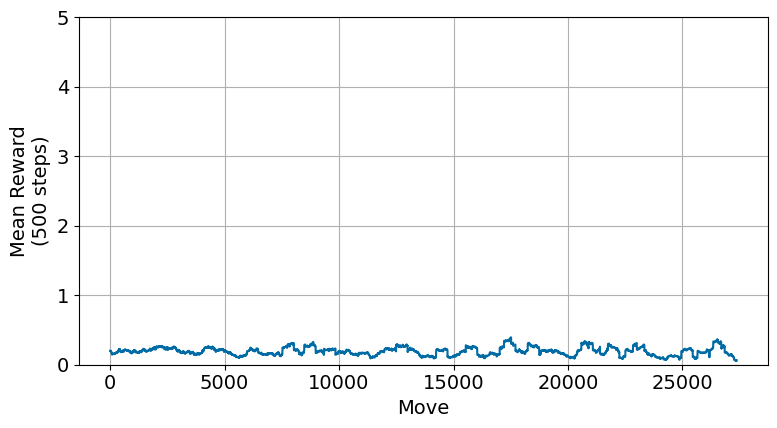

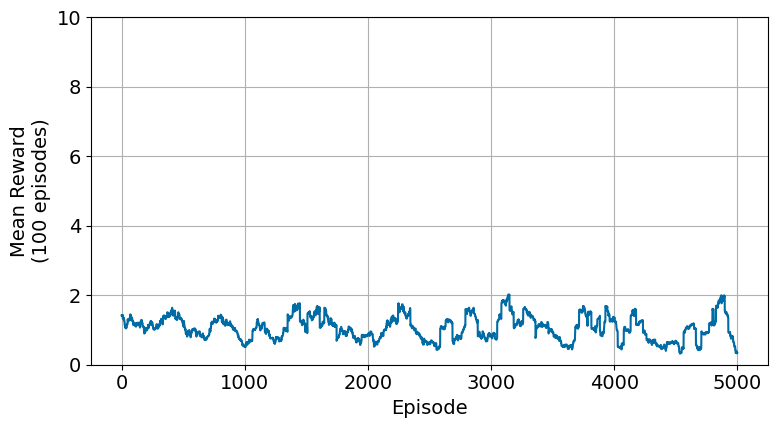

In [27]:
# Make plots
fig, ax = plot_step_rewards(step_rewards, save_path=os.path.join(figs_path, f"{model_name}_step_rewards.png"))
fig, ax = plot_episode_rewards(episode_rewards, save_path=os.path.join(figs_path, f"{model_name}_episode_rewards.png"), kernel_size=100)
plt.show()

In [19]:
# Generate all figures
model_names = [os.path.splitext(file)[0] for file in os.listdir(base_path) if os.path.splitext(file)[-1] == ".keras"]
for model_name in model_names:
    print(model_name)
    episode_rewards = np.loadtxt(os.path.join(base_path, f"{model_name}_episode_rewards.csv"), delimiter=",")
    step_rewards = np.loadtxt(os.path.join(base_path, f"{model_name}_step_rewards.csv"))
    fig, ax = plot_step_rewards(step_rewards, save_path=os.path.join(figs_path, f"{model_name}_step_rewards.png"))
    plt.close(fig)
    fig, ax = plot_episode_rewards(episode_rewards, save_path=os.path.join(figs_path, f"{model_name}_episode_rewards.png"))
    plt.close(fig)
    #plt.show()

random_nr_black
randomgreedy_pr_white
greedy_pr_black
randomgreedy_pr_black_large
random_pr_black_large
randomgreedy_pr_black
random_pr_black
greedy_nr_black
random_pr_white
random_pr_white_large
